In [3]:
#To ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import re
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
import nltk

from fuzzywuzzy import fuzz
from datetime import datetime

from sklearn.model_selection import train_test_split
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import log_loss

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [5]:
#Loading the dataset
data = pd.read_csv("Quora_questions.csv/questions.csv")
print("Shape of the dataset "+str(data.shape))
print("Number of datapoints "+str(data.shape[0]))
print("Number of features "+str(data.shape[1]))
data.head()

Shape of the dataset (404351, 6)
Number of datapoints 404351
Number of features 6


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
# Information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
id              404351 non-null int64
qid1            404351 non-null int64
qid2            404351 non-null int64
question1       404350 non-null object
question2       404349 non-null object
is_duplicate    404351 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
#################### Distribution of the datapoints among response labels #####################
# Number of duplicates(similar) and non_duplicates(non_similar) questions
# Taking the top 50k points
data = data.sample(n=50000)
data['is_duplicate'].value_counts()

0    31740
1    18260
Name: is_duplicate, dtype: int64

Text(0.5, 1.0, 'Class distribution \n (0:non_similar || 1:similar questions)')

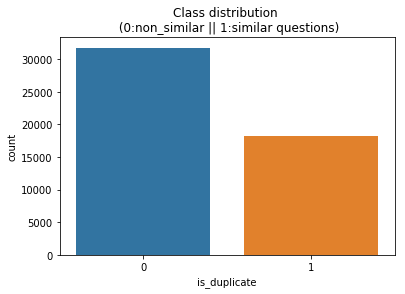

In [8]:
#Class distributions
sns.countplot(x='is_duplicate', data=data)
plt.title("Class distribution \n (0:non_similar || 1:similar questions)")

In [9]:
print("Non_duplicates questions are ",round((data['is_duplicate'].value_counts()[0]/len(data))*100, 3), "% of the dataset")
print("Duplicates questions are ",round((data['is_duplicate'].value_counts()[1]/len(data))*100, 3), "% of the dataset")

Non_duplicates questions are  63.48 % of the dataset
Duplicates questions are  36.52 % of the dataset


In [10]:
########### Number of unique questions #################
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

#q_vals=qids.value_counts()

#q_vals=q_vals.values

Total number of  Unique Questions are: 99559

Number of unique questions that appear more than one time: 383 (0.38469651161622753%)

Max number of times a single question is repeated: 11



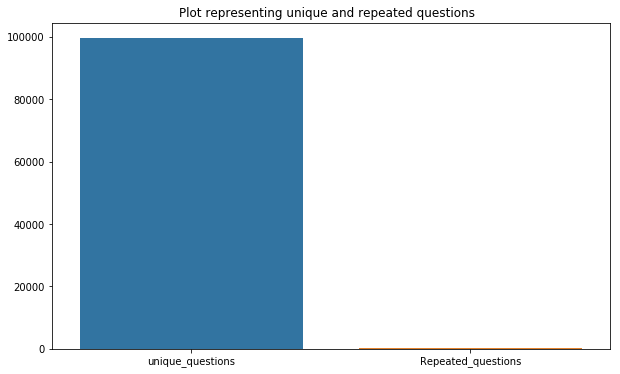

In [11]:
x = ['unique_questions', 'Repeated_questions']
y = [unique_qs, qs_morethan_onetime]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

Maximum number of times a single question is repeated: 11



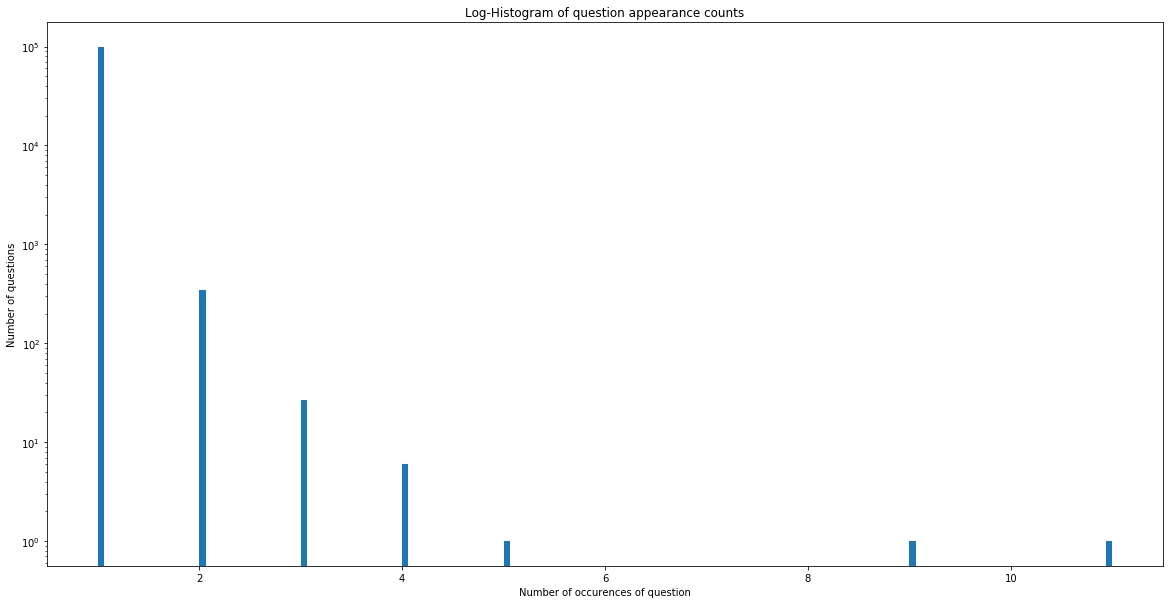

In [14]:
######################### Number of occurences for each question ##################
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [15]:
################## Checking the null values ##############
#Checking whether there are any rows with null values
nan_rows = data[data.isnull().any(1)]
# If values are present in theen replace with questions the space
print (nan_rows)

            id    qid1    qid2                         question1 question2  \
105796  105796  209841  209842    How can I develop android app?       NaN   
201871  201871  398348  398349  How can I create an Android app?       NaN   

        is_duplicate  
105796             0  
201871             0  


In [16]:
# If values are present in theen replace with questions the space
# Filling the null values with ' '
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Basic Feature Extraction:

- Length of the question.
- Difference between length of two questions.
- Character length of question without spaces.
- Number of words in question.
- Number of common words in both the questions.

In [17]:
# Length of question1
data['len_q1'] = data.question1.apply(lambda x: len(str(x)))
# Length of question2
data['len_q2'] = data.question2.apply(lambda x: len(str(x)))
# Difference in the two lengths
data['diff_len'] = data.len_q1 - data.len_q2
# Character length of question1 without spaces
data['len_char_q1'] = data.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
# Character length of question2 without spaces
data['len_char_q2'] = data.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
# Number of words in question1
data['len_word_q1'] = data.question1.apply(lambda x: len(str(x).split()))
# Number of words in question2
data['len_word_q2'] = data.question2.apply(lambda x: len(str(x).split()))
# Number of common words in question1 and question2
data['common_words'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [18]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
383194,383194,749346,749347,Why are Formula 1 cars slower than a Hennessey...,How many miles can a Bugatti Veyron do on a fu...,0,76,54,22,25,22,15,12,2
18194,18194,36303,36304,How can I improve my spoken English?,How can improve my English speaking?,1,36,36,0,21,20,7,6,4
303492,303492,595957,595958,Do we need to believe in God?,Do I need to believe in God?,1,29,28,1,13,13,7,7,6
24591,24591,49055,49056,Is it possible to derive the masses of electro...,What is electron proton neutron?,0,132,32,100,23,15,21,5,2
300573,300573,590319,590320,Which are the best SEO companies in Delhi?,"What is the best SEO company in Delhi, India?",1,42,45,-3,20,23,8,9,4


In [19]:
print ("Minimum length of the questions in question1 : " , min(data['len_word_q1']))

print ("Minimum length of the questions in question2 : " , min(data['len_word_q2']))

print ("Number of Questions with minimum length [question1] :", data[data['len_word_q1']==  min(data['len_word_q1'])].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['len_word_q2']==  min(data['len_word_q2'])].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  0
Number of Questions with minimum length [question1] : 7
Number of Questions with minimum length [question2] : 2


### Text Preprocessing:
   #### 1.Removal of HTML tags
   #### 2.Removal of special characters
   #### 3.Converting all text into small characters
   #### 4.Removing stop words
   #### 5.Stemming with porter stemming

In [20]:
######### Text preprocessing for both question_1 and question_2 ###########

#Storing all stopwords 
stop_words = set(stopwords.words('english'))

#stemming using porter stemming
sno = nltk.stem.SnowballStemmer('english')

#Function for removal of html tags, if present in the text
def cleanhtml(text):
    removed_html_text = re.sub('<.*?>', '', text)
    return removed_html_text

#Function for removal of punctuations from the text if present
def cleanpunc(text):
    text1 = re.sub(r'[?|!|\'|"|#]',r'',text)
    removed_punc = re.sub(r'[.|,|)|(|\|/]',r' ',text1)
    return removed_punc

In [24]:

#Function for Text pre-processing
def preprocess_data(data):
    #creating an empty list to store all preprocessed data
    preprocessed_data = []
    row = 0
    for sent in data:
            preprocessed_text = []
            #Removing html tags for each sentence 
            sent = cleanhtml(sent)
            for word in sent.split():
                #Removal of punctuations
                for c_word in cleanpunc(word).split():
                    #word should be non-numeric and length of each word should be >2 
                    if((c_word.isalpha()) & (len(c_word)>2)):
                        #Converting words to be in lower case and that should not be an stop words
                        if(c_word.lower() not in stop_words):
                            #Doing the stemming
                            final_word = (sno.stem(c_word.lower())).encode('utf8')
                            preprocessed_text.append(final_word)
                        else:
                            continue
                    else:
                        continue

            str = b' '.join(preprocessed_text).decode('utf8')
            preprocessed_data.append(str)
            #print(row, end='\r')
            row += 1
    return preprocessed_data

In [25]:
# Text_preprocessing for an question_1  
data['pre_question1'] = preprocess_data(data['question1'])

In [26]:
# Text_preprocessing for an question_1  
data['pre_question2'] = preprocess_data(data['question2'])

### Feature Extraction Using Fuzzy features:

- FuzzyWuzzy: Fuzzy String Matching in Python:https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [27]:
# Quentions Similarity
data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['pre_question1']), str(x['pre_question2'])), axis=1)
# Partial Questions similarity
data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['pre_question1']), str(x['pre_question2'])), axis=1)
# Token Set Sort
data['fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['pre_question1']), str(x['pre_question2'])), axis=1)
# Word similarity
data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['pre_question1']), str(x['pre_question2'])), axis=1)
data['fuzz_partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['pre_question1']), str(x['pre_question2'])), axis=1)
data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['pre_question1']), str(x['pre_question2'])), axis=1)
data['fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['pre_question1']), str(x['pre_question2'])), axis=1)

In [28]:
#Shape of the after adding all this features
print("Shape of the data "+str(data.shape))
data.head()

Shape of the data (50000, 23)


,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,...,common_words,pre_question1,pre_question2,fuzz_qratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_WRatio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio
383194,383194,749346,749347,Why are Formula 1 cars slower than a Hennessey...,How many miles can a Bugatti Veyron do on a fu...,0,76,54,22,25,...,2,formula car slower hennessey venom bugatti veyron,mani mile bugatti veyron full tank,43,58,53,55,100,50,58
18194,18194,36303,36304,How can I improve my spoken English?,How can improve my English speaking?,1,36,36,0,21,...,4,improv spoken english,improv english speak,68,65,88,84,100,90,88
303492,303492,595957,595958,Do we need to believe in God?,Do I need to believe in God?,1,29,28,1,13,...,6,need believ god,need believ god,100,100,100,100,100,100,100
24591,24591,49055,49056,Is it possible to derive the masses of electro...,What is electron proton neutron?,0,132,32,100,23,...,2,possibl deriv mass electron proton neutron fir...,electron proton neutron,47,100,47,90,100,52,100
300573,300573,590319,590320,Which are the best SEO companies in Delhi?,"What is the best SEO company in Delhi, India?",1,42,45,-3,20,...,4,best seo compani delhi,best seo compani delhi india,88,100,88,95,100,86,100


In [29]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2',
       'len_word_q1', 'len_word_q2', 'common_words', 'pre_question1',
       'pre_question2', 'fuzz_qratio', 'fuzz_partial_ratio',
       'fuzz_token_sort_ratio', 'fuzz_WRatio', 'fuzz_partial_token_set_ratio',
       'fuzz_partial_token_sort_ratio', 'fuzz_token_set_ratio'],
      dtype='object')

In [30]:
X = data.drop(['question1', 'question2', 'is_duplicate'], axis = 1)
y = data.is_duplicate

In [31]:
## Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Splitting the data has train and cross_validation
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_tr.shape, X_cv.shape, X_test.shape

((32000, 20), (8000, 20), (10000, 20))

## TF-IDF:

In [32]:
# tfidf for question1 
tf_q1 = TfidfVectorizer(lowercase=False).fit(X_tr.pre_question1)
tfidf_tr_mat_q1 =  tf_q1.transform(X_tr.pre_question1)
tfidf_cv_mat_q1 =  tf_q1.transform(X_cv.pre_question1)
tfidf_te_mat_q1 =  tf_q1.transform(X_test.pre_question1)

In [33]:
# tfidf for question2 
tf_q2 = TfidfVectorizer(lowercase=False).fit(X_tr.pre_question2)
tfidf_tr_mat_q2 =  tf_q2.transform(X_tr.pre_question2)
tfidf_cv_mat_q2 =  tf_q2.transform(X_tr.pre_question2)
tfidf_te_mat_q2 =  tf_q2.transform(X_test.pre_question2)

In [34]:
def tfidf_w2v(sentences, tfidf, tfidf_matrix):
    # tfidf feature names
    feature_names = tfidf.get_feature_names()
    tfidf_w2v = []
    for i, sent in enumerate(sentences):
        # suppose sentence is empty then making that into vector of zeros
        if len(sent.split()) == 0:
            tfidf_w2v.append(np.zeros(384))
        else:
            doc = nlp(sent)
            mean_vec = np.zeros(384)
            sum_tfidf = 0
            for word in doc:
                word_vec = word.vector
                try:
                    tfidf_value = tfidf_matrix[i, feature_names.index(str(word))]
                except:
                    tfidf_value = 0
                mean_vec += word_vec * tfidf_value
                sum_tfidf += tfidf_value
            if sum_tfidf != 0:
                mean_vec /= sum_tfidf
            tfidf_w2v.append(mean_vec)
        print(i, end='\r')
    return tfidf_w2v

In [35]:
nlp = spacy.load('en_core_web_sm')

In [36]:
start = datetime.now()
# tfidf_word2vectors of question_1 train data
X_tr_tfidf_w2v_q1 = tfidf_w2v(X_tr.pre_question1, tf_q1, tfidf_tr_mat_q1)
print("Time taken for tfidf_w2v of {} questions is {}".format(len(X_tr.pre_question1), datetime.now()-start))

Time taken for tfidf_w2v of 32000 questions is 0:15:35.888530


In [37]:
start = datetime.now()
# tfidf_word2vectors of question_1 train data
X_cv_tfidf_w2v_q1 = tfidf_w2v(X_cv.pre_question1, tf_q1, tfidf_cv_mat_q1)
print("Time taken for tfidf_w2v of {} questions is {}".format(len(X_cv.pre_question1), datetime.now()-start))

Time taken for tfidf_w2v of 8000 questions is 0:03:33.774227


In [38]:
start = datetime.now()
# Avg_word2vectors of question_1 test data
X_te_tfidf_w2v_q1 = tfidf_w2v(X_test.pre_question1, tf_q1, tfidf_te_mat_q1)
print("Time taken for tfidf_w2v of {} questions is {}".format(len(X_test.pre_question1), datetime.now()-start))

Time taken for tfidf_w2v of 10000 questions is 0:04:38.407924


In [39]:
start = datetime.now()
# tfidf_word2vectors of question_2 train data
X_tr_tfidf_w2v_q2 = tfidf_w2v(X_tr.pre_question2, tf_q2, tfidf_tr_mat_q2)
print("Time taken for tfidf_w2v of {} questions is {}".format(len(X_tr.pre_question2), datetime.now()-start))

Time taken for tfidf_w2v of 32000 questions is 0:13:51.926583


In [40]:
start = datetime.now()
# tfidf_word2vectors of question_2 train data
X_cv_tfidf_w2v_q2 = tfidf_w2v(X_cv.pre_question2, tf_q2, tfidf_cv_mat_q2)
print("Time taken for tfidf_w2v of {} questions is {}".format(len(X_cv.pre_question2), datetime.now()-start))

Time taken for tfidf_w2v of 8000 questions is 0:03:12.046985


In [41]:
start = datetime.now()
# tfidf_word2vectors of question_2 test data
X_te_tfidf_w2v_q2 = tfidf_w2v(X_test.pre_question2, tf_q2, tfidf_te_mat_q2)
print("Time taken for tfidf_w2v of {} questions is {}".format(len(X_test.pre_question2), datetime.now()-start))

Time taken for tfidf_w2v of 10000 questions is 0:04:00.663766


In [42]:
#Making the dataframes for train data
df_tr_tfidf_w2v_q1 = pd.DataFrame(X_tr_tfidf_w2v_q1)
df_tr_tfidf_w2v_q1 = df_tr_tfidf_w2v_q1.add_suffix('_q1')
df_tr_tfidf_w2v_q2 = pd.DataFrame(X_tr_tfidf_w2v_q2)
df_tr_tfidf_w2v_q2 = df_tr_tfidf_w2v_q2.add_suffix('_q2')

In [43]:
# Final tfidf_w2v train data
train_tfidf_w2v_x = pd.concat([df_tr_tfidf_w2v_q1, df_tr_tfidf_w2v_q2], axis=1)
train_tfidf_w2v_x.shape

(32000, 768)

In [44]:
#Making the dataframes for cv data
df_cv_tfidf_w2v_q1 = pd.DataFrame(X_cv_tfidf_w2v_q1)
df_cv_tfidf_w2v_q1 = df_cv_tfidf_w2v_q1.add_suffix('_q1')
df_cv_tfidf_w2v_q2 = pd.DataFrame(X_cv_tfidf_w2v_q2)
df_cv_tfidf_w2v_q2 = df_cv_tfidf_w2v_q2.add_suffix('_q2')

In [45]:
# Final tfidf_w2v cv data
eval_tfidf_w2v_x = pd.concat([df_cv_tfidf_w2v_q1, df_cv_tfidf_w2v_q2], axis=1)
eval_tfidf_w2v_x.shape

(8000, 768)

In [46]:
#Making the dataframes for test data
df_test_tfidf_w2v_q1 = pd.DataFrame(X_te_tfidf_w2v_q1)
df_test_tfidf_w2v_q1 = df_test_tfidf_w2v_q1.add_suffix('_q1')
df_test_tfidf_w2v_q2 = pd.DataFrame(X_te_tfidf_w2v_q2)
df_test_tfidf_w2v_q1 = df_test_tfidf_w2v_q1.add_suffix('_q2')

In [47]:
# Final tfidf_w2v test data
test_tfidf_w2v_x = pd.concat([df_test_tfidf_w2v_q1, df_test_tfidf_w2v_q2], axis=1)
test_tfidf_w2v_x.shape

(10000, 768)

In [48]:
# ############################ tfidf_w2v train, cv and test data parameters ###############################
# train_data parameters ====> train_tfidf_w2v_x, y_tr
# cv_data parameters    ====> eval_tfidf_w2v_x, y_cv
# test_data parameters  ====> test_tfidf_w2v_x, y_test

In [49]:
train_data = pd.concat([X_tr.drop(['pre_question1','pre_question2'], axis=1).reset_index(drop=True), train_tfidf_w2v_x], axis=1)
cv_data = pd.concat([X_cv.drop(['pre_question1','pre_question2'], axis=1).reset_index(drop=True), eval_tfidf_w2v_x], axis=1)
test_data = pd.concat([X_test.drop(['pre_question1','pre_question2'], axis=1).reset_index(drop=True), test_tfidf_w2v_x], axis=1)

train_data.shape, cv_data.shape, test_data.shape

((32000, 786), (8000, 786), (10000, 786))

In [60]:
#Function for calculating the metrics
def test_metrics(y_test, y_pred):
    cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
    sns.set(font_scale=1.5)
    sns.heatmap(cm,annot=True,annot_kws={"size": 20}, fmt='g', vmin=0, vmax=10000)

    print("Accuracy on test data:", round(accuracy_score(y_test, y_pred) * 100 , 2))
    print("Precision on test data:", round(precision_score(y_test, y_pred) * 100 , 2))
    print("Recall on test data:", round(recall_score(y_test, y_pred) * 100 , 2))
    print("F1_score on test data:", round(f1_score(y_test, y_pred) * 100,2))
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Building a Random Model:

Log loss on Test Data using Random Model 0.8946890361005037
Accuracy on test data: 49.87
Precision on test data: 36.97
Recall on test data: 49.81
F1_score on test data: 42.44


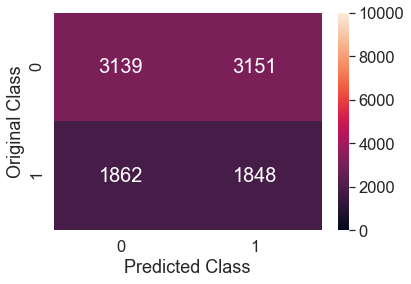

In [61]:
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
test_metrics(y_test, predicted_y)

## Models Building:

In [52]:
def train_model(hyperparameters, train_x, train_y, cv_x, cv_y, loss):
    #Finding the best hyperparameter using the cross validation
    cv_log_errors = []
    train_acc = []
    cv_acc = []
    for x in hyperparameters:
        clf = SGDClassifier(alpha=x, loss=loss, random_state=42, class_weight='balanced')
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf,  method='sigmoid')
        sig_clf.fit(train_x, train_y)
        predict_y = sig_clf.predict_proba(cv_x)
        cv_log_errors.append(log_loss(cv_y, predict_y,labels=clf.classes_, eps=1e-15))
        train_acc.append(accuracy_score(train_y, sig_clf.predict(train_x)))
        cv_acc.append(accuracy_score(cv_y, sig_clf.predict(cv_x)))
        print('For values of alpha = ', x, "The log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
    
    return cv_log_errors, train_acc, cv_acc

In [53]:
### cross_validation loss plot
def cv_loss_plot(hyperparameters, cv_errors):
    plt.plot(hyperparameters, cv_errors)
    plt.title("Cross Validation Error for each hyperparameters")
    plt.xlabel("Hyperparameters")
    plt.ylabel("Error measure")
    plt.show()

In [54]:
### Train and cv accuracy plot
def train_cv_acc(hyperparameters, train_acc, cv_acc):
    plt.plot(hyperparameters, train_acc, label='train')
    plt.plot(hyperparameters, cv_acc, label='cv')
    plt.title("Train_loss vs cv_loss")
    plt.xlabel("Hyperparameters")
    plt.ylabel("Accuracies")
    plt.legend()
    plt.show()

In [55]:
#best_alhpha, loss, train_x, train_y, cv_x, cv_y, test_x, test_y
def testing_model(best_alhpha, loss, train_x, train_y, cv_x, cv_y, test_x, test_y):
    ### Using the best_alpha finding train_loss, cv_loss and test_loss  
    clf = SGDClassifier(alpha=best_alpha, loss=loss, random_state=42, class_weight='balanced')
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf,  method='sigmoid')
    sig_clf.fit(train_x, train_y)

    # training loss 
    pred_y = sig_clf.predict_proba(train_x)
    print("Train log_loss with best_hyperparameter"+str(log_loss(train_y, pred_y, labels=clf.classes_, eps=1e-15)))

    # cv_loss 
    pred_y = sig_clf.predict_proba(cv_x)
    print("cross validation log_loss with best_hyperparameter"+str(log_loss(cv_y, pred_y, labels=clf.classes_, eps=1e-15)))

    # Test loss 
    pred_y = sig_clf.predict_proba(test_x)
    print("Test log_loss with best_hyperparameter"+str(log_loss(test_y, pred_y, labels=clf.classes_, eps=1e-15)))

    y_pred = sig_clf.predict(test_x)

    # Calling function for calculating the metrics
    print("*"*20, "performance metrics", "*"*20)
    test_metrics(y_test, y_pred)

In [56]:
# Standardizing the data
scaler = StandardScaler().fit(train_data)
train_data_std = scaler.transform(train_data)
cv_data_std = scaler.transform(cv_data)
test_data_std = scaler.transform(test_data)

## 1. Logistic Regression:

For values of alpha =  1e-05 The log loss is: 0.5751224928733218
For values of alpha =  0.0001 The log loss is: 0.5724635618107715
For values of alpha =  0.001 The log loss is: 0.5708767366280906
For values of alpha =  0.01 The log loss is: 0.5389555093240642
For values of alpha =  0.1 The log loss is: 0.5344885907049003
For values of alpha =  1 The log loss is: 0.540018264741861


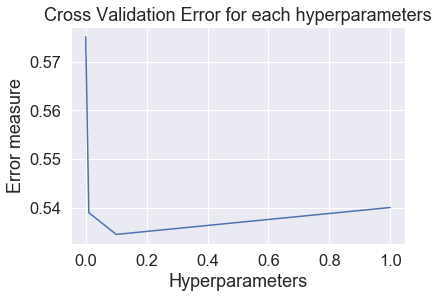

best_alpha 0.1


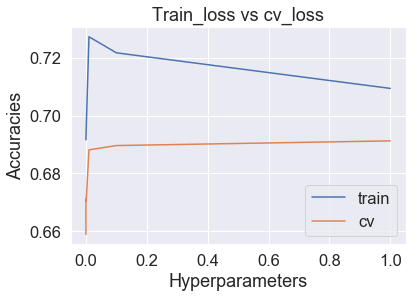

Train log_loss with best_hyperparameter0.5580990185920305
cross validation log_loss with best_hyperparameter0.5556680668138968
Test log_loss with best_hyperparameter0.5602764225282751
******************** performance metrics ********************
Accuracy on test data: 68.74
Precision on test data: 61.07
Recall on test data: 43.42
F1_score on test data: 50.76


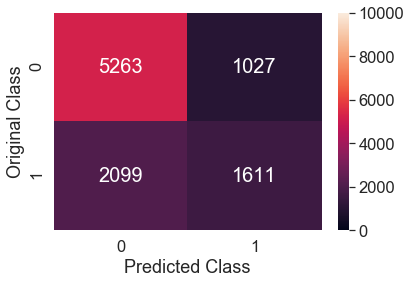

In [62]:
alpha = [10 ** x for x in range(-5,1)]
cv_log_errors, train_accuracies, cv_accuracies = train_model(alpha, train_data_std, y_tr, cv_data_std, y_cv, 'log')

# cross_validation loss plot
cv_loss_plot(alpha, cv_log_errors)

# Finding the best alpha
best_alpha = np.argmin(cv_log_errors)
print("best_alpha "+str(alpha[best_alpha]))

# Train and cv accuracy plot
train_cv_acc(alpha, train_accuracies, cv_accuracies)

# Testing the model with the best_hyperparameter
testing_model(best_alpha, 'log', train_data_std, y_tr, cv_data_std, y_cv , test_data_std, y_test)

## Linear SVM:

For values of alpha =  1e-06 The log loss is: 0.5781061955539624
For values of alpha =  1e-05 The log loss is: 0.5753170328576437
For values of alpha =  0.0001 The log loss is: 0.5728511393899718
For values of alpha =  0.001 The log loss is: 0.5708407482716819
For values of alpha =  0.01 The log loss is: 0.5420866481528028
For values of alpha =  0.1 The log loss is: 0.5395050909113223
For values of alpha =  1 The log loss is: 0.540329858406837
For values of alpha =  10 The log loss is: 0.552500228064991
For values of alpha =  100 The log loss is: 0.5968472497389491


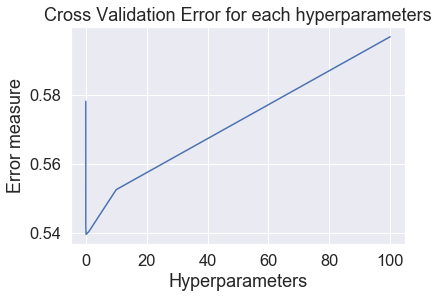

best_alpha 0.1


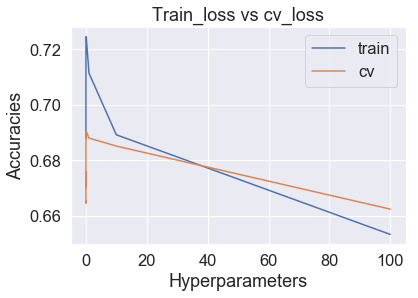

Train log_loss with best_hyperparameter0.5408639673806417
cross validation log_loss with best_hyperparameter0.5467643862457778
Test log_loss with best_hyperparameter0.5429944219141122
******************** performance metrics ********************
Accuracy on test data: 69.65
Precision on test data: 61.64
Recall on test data: 48.17
F1_score on test data: 54.08


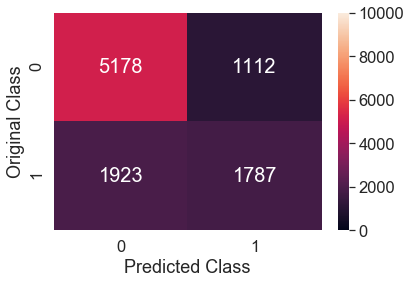

In [63]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_errors, train_accuracies, cv_accuracies = train_model(alpha, train_data_std, y_tr, cv_data_std, y_cv, 'hinge')

# cross_validation loss plot
cv_loss_plot(alpha, cv_log_errors)

# Finding the best alpha
best_alpha = np.argmin(cv_log_errors)
print("best_alpha "+str(alpha[best_alpha]))

# Train and cv accuracy plot
train_cv_acc(alpha, train_accuracies, cv_accuracies)

# Testing the model with the best_hyperparameter
testing_model(best_alpha, 'hinge', train_data_std, y_tr, cv_data_std, y_cv , test_data_std, y_test)

## 2. Random Forest:

For n_estimators= 100 and max_depth= 5
Log loss: 0.5248022215660264
For n_estimators= 100 and max_depth= 10
Log loss: 0.514006025379395
For n_estimators= 500 and max_depth= 5
Log loss: 0.524118787458757
For n_estimators= 500 and max_depth= 10
Log loss: 0.5128715438650715
For n_estimators= 1000 and max_depth= 5
Log loss: 0.5239354878731352
For n_estimators= 1000 and max_depth= 10
Log loss: 0.5127310545855814
For n_estimators= 1500 and max_depth= 5
Log loss: 0.5239493298839998
For n_estimators= 1500 and max_depth= 10
Log loss: 0.5128083354139961
Train log_loss with best_hyperparameter0.3552919671479046
cross validation log_loss with best_hyperparameter0.5127310545855814
Test log_loss with best_hyperparameter0.49390344671916453
******************** performance metrics ********************
Accuracy on test data: 73.51
Precision on test data: 64.43
Recall on test data: 63.85
F1_score on test data: 64.14


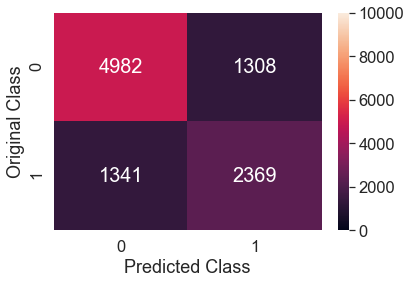

In [64]:
#train_avg_w2v_x, y_tr, eval_avg_w2v_x, y_cv , test_avg_w2v_x, y_test
num_trees = [100, 500, 1000, 1500]
max_depth = [5, 10]
cv_log_errors = []
for trees in num_trees:
    for depth in max_depth:
        print("For n_estimators=", trees,  "and max_depth=", depth)
        clf = RandomForestClassifier(n_estimators=trees, criterion='gini',  max_depth=depth, random_state=42, n_jobs=3)
        clf.fit(train_data_std, y_tr)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_data_std, y_tr)
        sig_clf_probs = sig_clf.predict_proba(cv_data_std)
        cv_log_errors.append(log_loss(y_cv, sig_clf_probs))
        print("Log loss:", log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Training the model using the best hyperparameter
best_params = np.argmin(cv_log_errors)
clf = RandomForestClassifier(n_estimators=num_trees[int(best_params/2)], criterion='gini',  max_depth=max_depth[int(best_params%2)], random_state=42, n_jobs=3)
clf.fit(train_data_std, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data_std, y_tr)

# training loss 
pred_y = sig_clf.predict_proba(train_data_std)
print("Train log_loss with best_hyperparameter"+str(log_loss(y_tr, pred_y, labels=clf.classes_, eps=1e-15)))

# cv_loss 
pred_y = sig_clf.predict_proba(cv_data_std)
print("cross validation log_loss with best_hyperparameter"+str(log_loss(y_cv, pred_y, labels=clf.classes_, eps=1e-15)))

# Test loss 
pred_y = sig_clf.predict_proba(test_data_std)
print("Test log_loss with best_hyperparameter"+str(log_loss(y_test, pred_y, labels=clf.classes_, eps=1e-15)))

y_pred = sig_clf.predict(test_data_std)

# Calling function for calculating the metrics
print("*"*20, "performance metrics", "*"*20)
test_metrics(y_test, y_pred)

## xgboost:

In [69]:
dtrain = xgb.DMatrix(train_data_std, label=y_tr)
dtest  = xgb.DMatrix(test_data_std)

In [70]:
params = {'objective':'binary:logistic',
         'max_depth':4,
         'silent':1,
         'eta':0.15,
        'eval_metric' : 'logloss'}
num_rounds = 150

In [71]:
ratio = float(np.sum(y==0)) / np.sum(y==1)
params['scale_pos_weight'] = ratio

In [72]:
bst = xgb.train(params, dtrain, num_rounds)
#y_test_preds = (bst.predict(dtest)>0.5).astype('int')
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The test log loss is: 0.4782615309052009
